In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import time
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from torchvision import transforms as T
from torchvision.datasets import MNIST, CIFAR10
from tqdm import tqdm_notebook as tqdm
from skimage import io
import os

In [3]:
default_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
default_device

device(type='cuda', index=0)

In [4]:
class HeartCyclesDataset(Dataset):
    """Cycles dataset."""

    def __init__(self, root_dir, csv_path, transform=None):
        """
        Arguments:
            root_dir (string): a path to root dir of images and csv file
        """
        self.root_dir = root_dir
        self.csvFile = pd.read_csv(csv_path)
        self.transform = transform

    def __len__(self):
        return len(self.csvFile)

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, str(self.csvFile.iloc[idx, 0])+'.png')
        image = io.imread(img_name)
        label = self.csvFile.iloc[idx, 5]

        sample = {'image': image, 'label': label}

        if self.transform:
            sample['image'] = self.transform(sample['image'])
            # sample['image'] = torch.permute(sample['image'], (2,0,1))

        return sample

In [5]:
root = './drive/MyDrive/root_dir/'
csv_path = root + 'dataset.csv'
cycles_dataset = HeartCyclesDataset(root, csv_path)

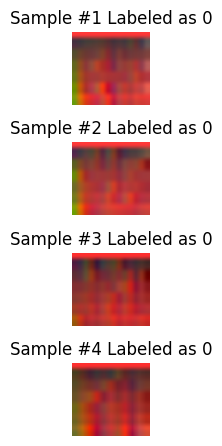

In [6]:
fig = plt.figure()

for i, sample in enumerate(cycles_dataset):

    ax = plt.subplot(4, 1, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{0} Labeled as {1}'.format(i+1, sample['label']))
    ax.imshow(sample['image'])
    ax.axis('off')

    if i == 3:
        plt.show()
        break

In [7]:
class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super(block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels, intermediate_channels, kernel_size=1, stride=1, padding=0, bias=False
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)


def ResNet50(img_channel=3, num_classes=2):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)


def ResNet101(img_channel=3, num_classes=2):
    return ResNet(block, [3, 4, 23, 3], img_channel, num_classes)


def ResNet152(img_channel=3, num_classes=2):
    return ResNet(block, [3, 8, 36, 3], img_channel, num_classes)

In [8]:
# Hyperparameters:
batch_size = 64
learning_rate = 1e-4
epochs = 10
criterion = nn.CrossEntropyLoss()

# Premade Model From Tutorial Train and Test:
model = ResNet101().to(default_device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
# Train, Validation, Test split:
classes = ('healthy', 'sick')
full_train_size = int(0.8 * len(cycles_dataset))
test_size = len(cycles_dataset) - full_train_size
train_size = int(0.8 * full_train_size)
validation_size = full_train_size - train_size
full_train_set, test_set = torch.utils.data.random_split(cycles_dataset, [full_train_size, test_size])
train_set, validation_set = torch.utils.data.random_split(full_train_set, [train_size, validation_size])

# dataloaders ‑ creating batches and shuffling the data
cycles_dataset = HeartCyclesDataset(root, csv_path, transform=T.ToTensor())
trainloader = torch.utils.data.DataLoader(
train_set, batch_size=batch_size, shuffle=True, num_workers=2)
validationloader = torch.utils.data.DataLoader(
validation_set, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(
test_set, batch_size=batch_size, shuffle=False, num_workers=2)

# device ‑ cpu or gpu?
default_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using {default_device}')

Using cuda:0


In [21]:
# Returns the model's accuracy and confusion matrix:
def calculate_accuracy(model, dataloader, device):
  model.eval() # put in evaluation mode
  total_correct = 0
  total_images = 0
  confusion_matrix = np.zeros([10,10], int)
  with torch.no_grad():
    for data in dataloader:
      inputs = data['image']
      labels = data['label']
      # send them to device
      inputs = inputs.to(device)
      inputs = torch.permute(inputs, (0,3,1,2)).float()
      labels = labels.to(device)
      outputs = model(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total_images += labels.size(0)
      total_correct += (predicted == labels).sum().item()
      for i, l in enumerate(labels):
        confusion_matrix[l.item(), predicted[i].item()] += 1

  model_accuracy = total_correct / total_images * 100
  return model_accuracy, confusion_matrix

In [22]:
# Train model for a given amount of epochs and criterion
def train_model(model, epochs, t_loader, v_loader, optimizer, criterion, path, device):
  # training loop
  for epoch in range(1, epochs + 1):
    model.train() # put in training mode
    running_loss = 0.0
    epoch_time = time.time()
    for i, data in enumerate(t_loader, 0):
      # get the inputs
      inputs = data['image']
      labels = data['label']
      # send them to device
      inputs = inputs.to(device)
      inputs = torch.permute(inputs, (0,3,1,2)).float()
      labels = labels.to(device)
      # forward + backward + optimize
      outputs = model(inputs) # forward pass
      loss = criterion(outputs, labels) # calculate the loss
      # always the same 3 steps
      optimizer.zero_grad() # zero the parameter gradients
      loss.backward() # backpropagation
      optimizer.step() # update parameters
      # print statistics
      running_loss += loss.data.item()
    # Normalizing the loss by the total number of train batches
    running_loss /= len(t_loader)
    # Calculate training/test set accuracy of the existing model
    train_accuracy, _ = calculate_accuracy(model, t_loader, device)
    validation_accuracy, _ = calculate_accuracy(model, v_loader, device)
    log = "Epoch: {} | Loss: {:.4f} | Training accuracy: {:.3f}% | Test accuracy: {:.3f}% | ".format(epoch, running_loss, train_accuracy, validation_accuracy)
    epoch_time = time.time() - epoch_time
    log += "Epoch Time꞉ {:.2f} secs".format(epoch_time)
    print(log)
    # save model
    if epoch % epochs == 0:
      print('==> Saving model ...')
      state = {'net': model.state_dict(),
              'epoch': epoch,
      }
      if not os.path.isdir('checkpoints'):
        os.mkdir('checkpoints')
      torch.save(state, path)
  print('==> Finished Training ...')

In [23]:
train_model(model, epochs, trainloader, validationloader, optimizer, criterion, root+'./model_statedict.pth', default_device)

Epoch: 1 | Loss: 0.7132 | Training accuracy: 62.164% | Test accuracy: 61.785% | Epoch Time꞉ 638.50 secs
Epoch: 2 | Loss: 0.7032 | Training accuracy: 61.229% | Test accuracy: 62.243% | Epoch Time꞉ 27.47 secs
Epoch: 3 | Loss: 0.6924 | Training accuracy: 62.316% | Test accuracy: 62.014% | Epoch Time꞉ 25.88 secs
Epoch: 4 | Loss: 0.6735 | Training accuracy: 69.033% | Test accuracy: 54.310% | Epoch Time꞉ 27.11 secs
Epoch: 5 | Loss: 0.6492 | Training accuracy: 73.765% | Test accuracy: 55.072% | Epoch Time꞉ 24.67 secs
Epoch: 6 | Loss: 0.6319 | Training accuracy: 79.431% | Test accuracy: 55.454% | Epoch Time꞉ 25.21 secs
Epoch: 7 | Loss: 0.5889 | Training accuracy: 75.444% | Test accuracy: 60.564% | Epoch Time꞉ 25.73 secs
Epoch: 8 | Loss: 0.5579 | Training accuracy: 83.209% | Test accuracy: 60.031% | Epoch Time꞉ 26.63 secs
Epoch: 9 | Loss: 0.5075 | Training accuracy: 84.030% | Test accuracy: 55.835% | Epoch Time꞉ 25.49 secs
Epoch: 10 | Loss: 0.4739 | Training accuracy: 86.892% | Test accuracy: 5